Prophet example.

Note, we will show that Prophet's solution structure doesn't match our problem structure. But Prophet's solution structure may very much match your problem structure.

## Setting up our example

In [1]:
# set up Python
import numpy as np
import pandas as pd
from prophet import Prophet
from plotnine import *


In [2]:

d_train = pd.read_csv("d_train.csv")
d_test = pd.read_csv("d_test.csv")


## Prophet

### Prophet without external regressors

In [3]:
# https://facebook.github.io/prophet/docs/quick_start.html#python-api
m = Prophet()

In [4]:
test_date = pd.to_datetime('2024-10-30').date()
train_date = test_date - pd.to_timedelta(d_train.shape[0] + 1, unit='days')

In [5]:
d_train_p = pd.DataFrame({
    'ds': [train_date + pd.to_timedelta(i, unit='days') for i in range(d_train.shape[0])],
    'y': d_train['y']
})

d_train_p

,ds,y
0,2022-03-24,52.987245
1,2022-03-25,72.018009
2,2022-03-26,55.200982
3,2022-03-27,56.176554
4,2022-03-28,58.765894
...,...,...
945,2024-10-24,87.264384
946,2024-10-25,63.471826
947,2024-10-26,75.430295
948,2024-10-27,52.053845


In [6]:
m.fit(d_train_p)


23:31:38 - cmdstanpy - INFO - Chain [1] start processing
23:31:38 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future = m.make_future_dataframe(periods=d_test.shape[0])
forecast = m.predict(future)


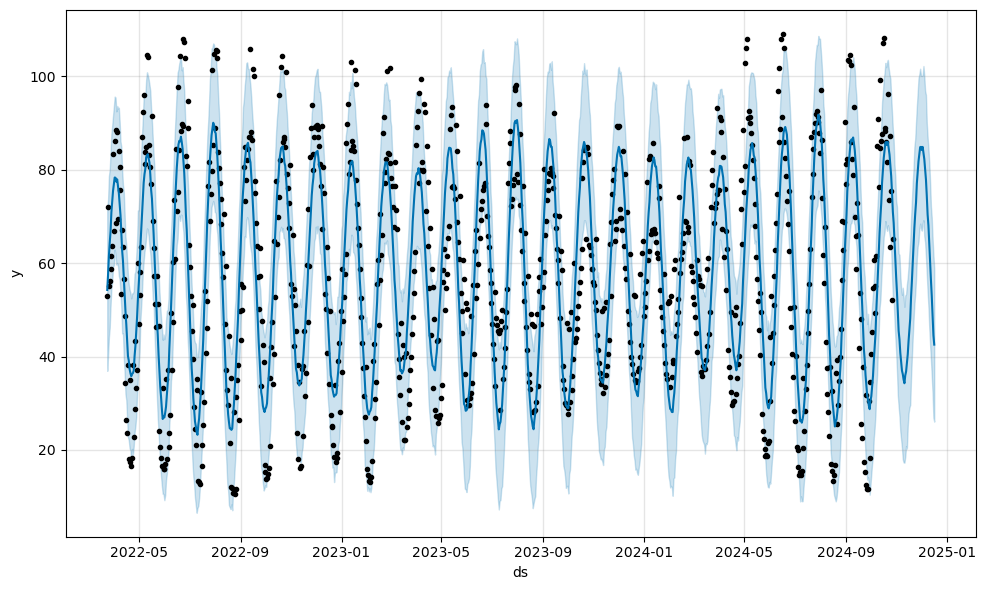

In [8]:
_ = m.plot(forecast)

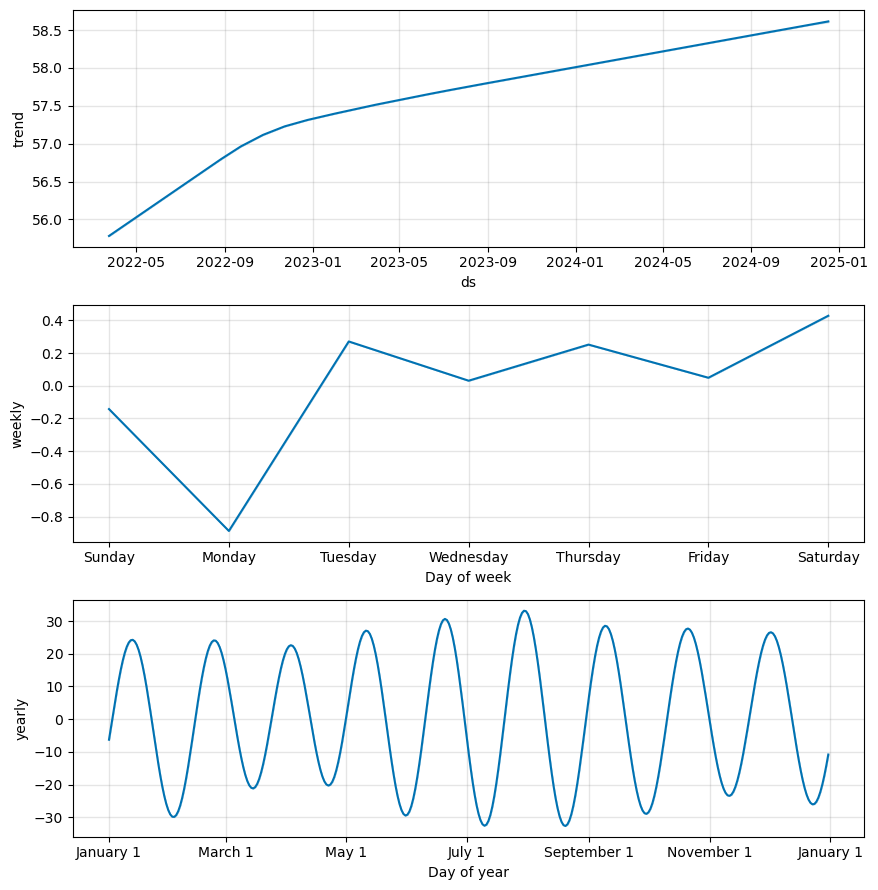

In [9]:
_ = m.plot_components(forecast)

In [10]:
forecast.shape

(1000, 19)

In [11]:
d_train.shape

(950, 5)

In [12]:
d_test.shape

(50, 5)

In [13]:
d_test['Prophet prediction (no external regressors)'] = np.array(
    forecast.loc[range(d_train.shape[0], d_train.shape[0] + d_test.shape[0]), 'yhat']
)

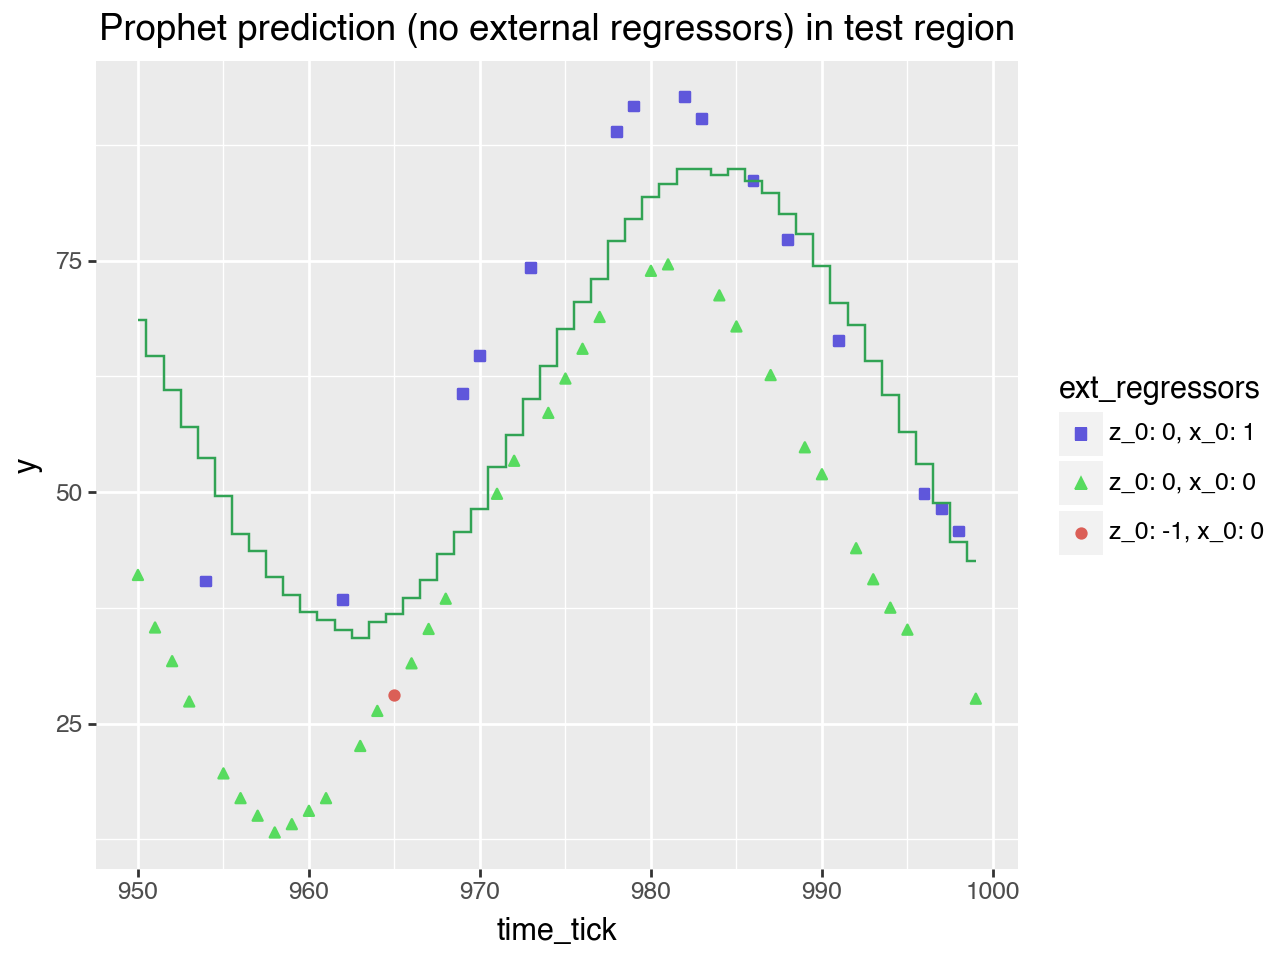

In [14]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis='columns'), :],
        mapping=aes(x='time_tick')
    )
    + geom_point(aes(y='y', shape='ext_regressors', color='ext_regressors'))
    + geom_step(
        aes(y='Prophet prediction (no external regressors)'),
        color='#31a354',
        direction='mid',
        )
    + guides(shape=guide_legend(reverse=True))
    + ggtitle('Prophet prediction (no external regressors) in test region')
)

### Prophet with external regressors

In [15]:
m_ext = Prophet()
m_ext.add_regressor('z_0')
m_ext.add_regressor('x_0')

In [16]:
test_date = pd.to_datetime('2024-10-30').date()
train_date = test_date - pd.to_timedelta(d_train.shape[0] + 1, unit='days')

In [17]:
d_train_p = pd.DataFrame({
    'ds': [train_date + pd.to_timedelta(i, unit='days') for i in range(d_train.shape[0])],
    'y': d_train['y'],
    'z_0': d_train['z_0'],
    'x_0': d_train['x_0'],
})

d_train_p

,ds,y,z_0,x_0
0,2022-03-24,52.987245,0,0
1,2022-03-25,72.018009,0,1
2,2022-03-26,55.200982,0,0
3,2022-03-27,56.176554,0,0
4,2022-03-28,58.765894,1,0
...,...,...,...,...
945,2024-10-24,87.264384,0,1
946,2024-10-25,63.471826,0,0
947,2024-10-26,75.430295,0,1
948,2024-10-27,52.053845,0,0


In [18]:
m_ext.fit(d_train_p)

23:31:39 - cmdstanpy - INFO - Chain [1] start processing
23:31:40 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
future_ext = m_ext.make_future_dataframe(periods=d_test.shape[0])
future_ext['z_0'] = pd.concat([d_train['z_0'], d_test['z_0']], ignore_index=True)
future_ext['x_0'] = pd.concat([d_train['x_0'], d_test['x_0']], ignore_index=True)

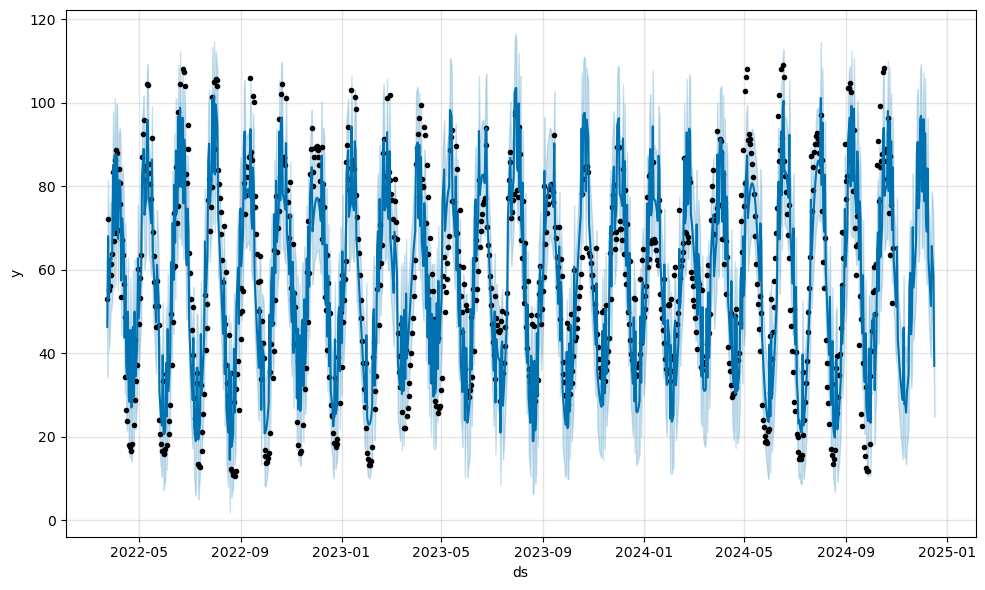

In [20]:
forecast_ext = m_ext.predict(future_ext)
_ = m_ext.plot(forecast_ext)

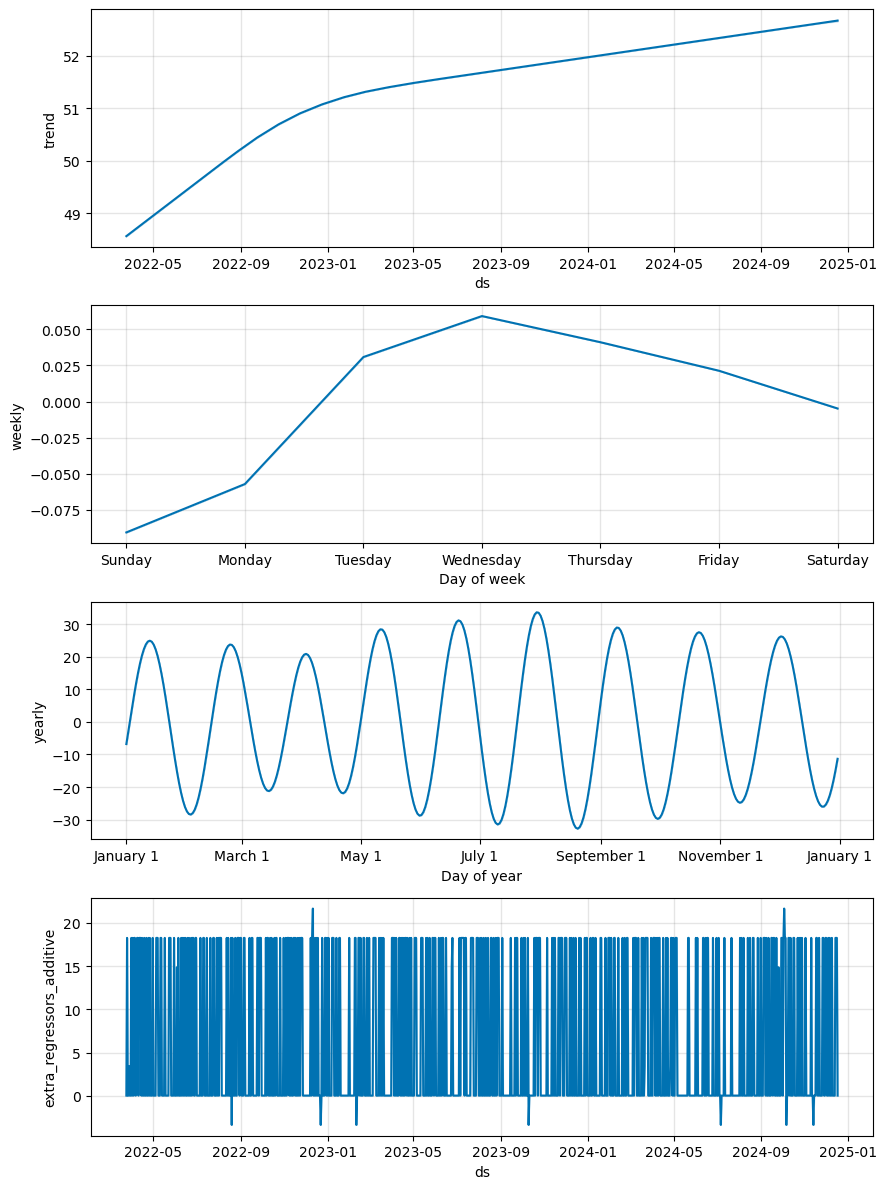

In [21]:
_ = m_ext.plot_components(forecast_ext)

In [22]:
d_test['Prophet prediction (with external regressors)'] = np.array(
    forecast_ext.loc[range(d_train.shape[0], d_train.shape[0] + d_test.shape[0]), 'yhat']
)

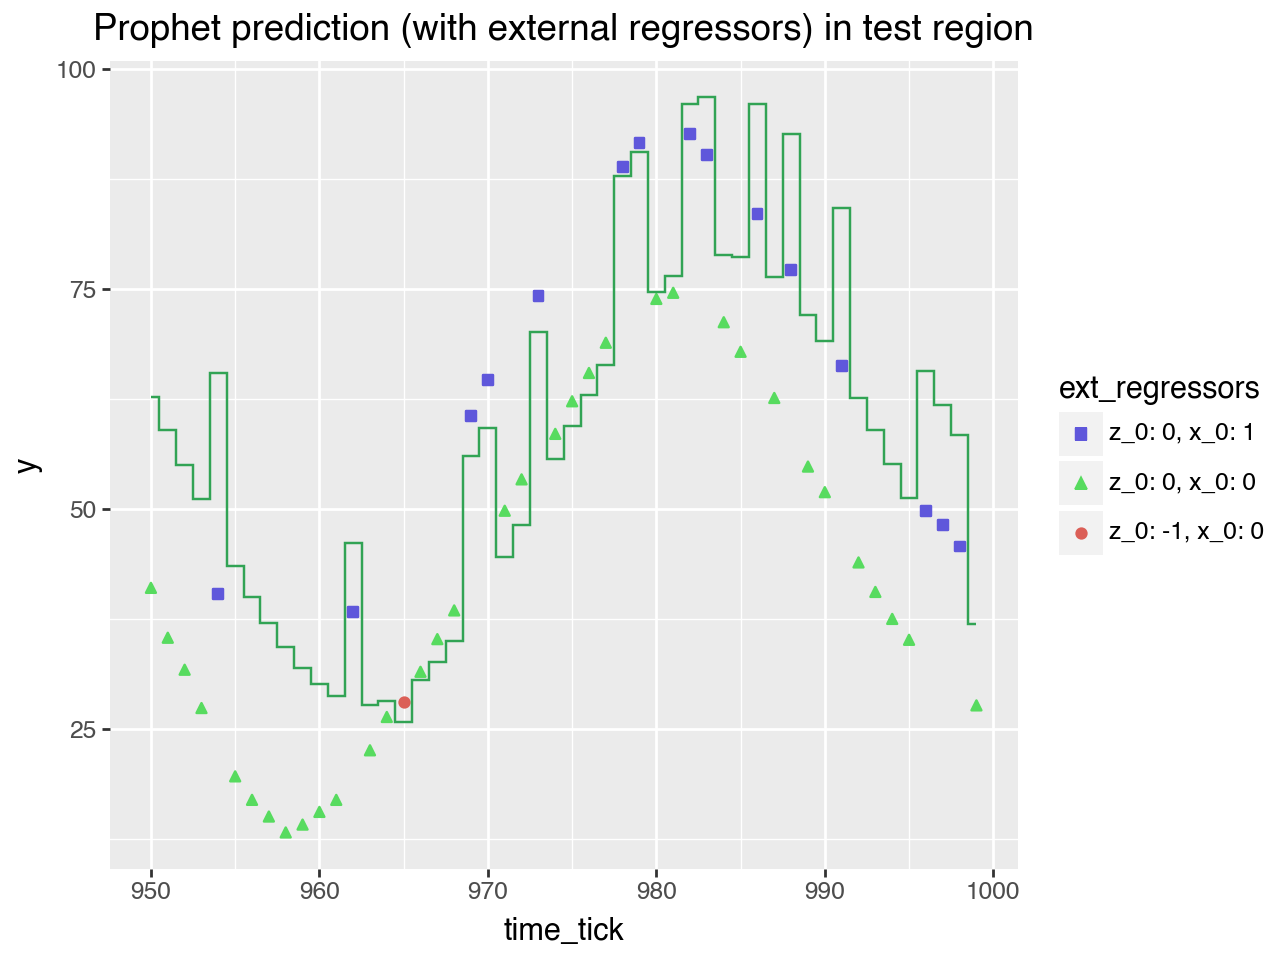

In [23]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis='columns'), :],
        mapping=aes(x='time_tick')
    )
    + geom_point(aes(y='y', shape='ext_regressors', color='ext_regressors'))
    + geom_step(
        aes(y='Prophet prediction (with external regressors)'),
        color='#31a354',
        direction='mid',
        )
    + guides(shape=guide_legend(reverse=True))
    + ggtitle('Prophet prediction (with external regressors) in test region')
)